## Imports

In [1]:
from fastai import *
import numpy as np
import torch
import torch.utils.data as torchdata
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from skimage import draw
import matplotlib.pyplot as plt
import pdb
from fastai import *

import aggdraw
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence

%matplotlib inline

## Bezier data generation

In [28]:
def bezier2image(bez, image_shape):
    img = Image.new("L", image_shape, "black")
    canvas = aggdraw.Draw(img)
    pen = aggdraw.Pen("white")
    path = aggdraw.Path()
    path.moveto(*bez[0:2])
    path.curveto(*bez)
    canvas.path(path, path.coords(), pen)
    canvas.flush()
    arr = np.array(img)/255.
    return arr

In [177]:
def generate_render_sequence(count, action_shape, action_scaler, render_shape, prefix, min_seq_len= 5, max_seq_len=5, keep_intermediate=False, seed=123):
    rs = np.random.RandomState(seed=seed)
    index = pd.DataFrame({'image_name':[], 'seq_idx':[], 'act_idx':[], 'actions':[], 'action':[]})
    seq_lens = rs.randint(min_seq_len, max_seq_len+1, (count,))
    for seq_idx in progress_bar(range(count)):
        seq_len = seq_lens[seq_idx]
        actions = rs.rand(seq_len, *action_shape)
        render = np.zeros(render_shape)
        img = Image.new("L", render_shape, "black")
        canvas = aggdraw.Draw(img)
        pen = aggdraw.Pen("white")
        for act_idx in range(seq_len):
            bez = actions[act_idx] * action_scaler
            path = aggdraw.Path()
            path.moveto(*bez[0:2])
            path.curveto(*bez)
            canvas.path(path, path.coords(), pen)
            if keep_intermediate:
                canvas.flush()
                arr = np.array(img)/255.
                fname = f"{prefix}{seq_idx}-{act_idx}.npy"
                np.save(fname, arr)
                index = index.append({
                    'image_name': fname, 
                    'seq_idx': seq_idx, 
                    'act_idx': act_idx, 
                    'actions': actions[0:act_idx+1], 
                    'action':actions[act_idx]},
                    ignore_index=True
                )
        if not keep_intermediate:
            canvas.flush()
            arr = np.array(img)/255.
            fname = f"{prefix}{seq_idx}.npy"
            np.save(fname, arr)
            index = index.append({
                'image_name': fname, 
                'seq_idx': seq_idx, 
                'act_idx': act_idx, 
                'actions': actions[0:act_idx+1], 
                'action':actions[act_idx]},
                ignore_index=True
            )
    return index

In [161]:
def generate_canvas_df(count):    
    render_index = generate_render_sequence(count, (6,), 64, (64, 64), 'data/canvas/', 1, 5, True)
    
    canvas_df = (
        render_index
        .sort_values(['seq_idx', 'act_idx'])
        .assign(prev_image_name=render_index.shift(1).image_name)
    )
    canvas_df.loc[canvas_df.act_idx == 0, 'prev_image_name'] = None
    
    return canvas_df[['image_name', 'prev_image_name', 'action']]

In [162]:
def generate_drawer_df(count):    
    render_index = generate_render_sequence(count, (6,), 64, (64, 64), 'data/drawer/', 5, 5)
    return render_index[['image_name']]

In [178]:
drawer_df = generate_drawer_df(20000)
#canvas_df.to_csv('canvas_df')
drawer_df.to_csv('drawer_df.csv')

In [179]:
canvas_df = pd.read_csv('canvas_df.csv')
canvas_df.action = canvas_df.action.map(lambda a: pd.to_numeric(a[1:-1].split()))
drawer_df = pd.read_csv('drawer_df.csv')

## Dataset classes

In [4]:
class CanvasDataset(Dataset):
    def __init__(self, canvas_df):
        self.count = len(canvas_df)
        self.df = canvas_df.reset_index()
    def __len__(self):
        return self.count
    def __getitem__(self, idx):
        item = self.df.loc[idx]
        prev = item.prev_image_name
        image = torch.tensor(np.load(item.image_name), dtype=torch.float).unsqueeze(0)
        hint = torch.tensor(np.load(prev), dtype=torch.float).unsqueeze(0) if prev is not np.nan else torch.zeros_like(image)
        action = torch.tensor(item.action, dtype=torch.float)
        return (hint, action), image

In [5]:
class DrawerDataset(Dataset):
    def __init__(self, drawer_df):
        self.count = len(drawer_df)
        self.df = drawer_df.reset_index()
    def __len__(self):
        return self.count
    def __getitem__(self, idx):
        item = self.df.loc[idx]
        image = torch.tensor(np.load(item.image_name), dtype=torch.float).unsqueeze(0)
        return image, image

## Shared layer definitions and model functions

In [6]:
def ConvPyramid():
    return nn.Sequential(
        nn.Conv2d(3, 4, 3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(4, 8, 3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(8, 32, 3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
    )

In [7]:
def ConvLayer(in_channels, out_channels, kernel_size, stride, last=False):
    pad_a = kernel_size // 2
    pad_b = (pad_a - 1) if kernel_size % 2 == 0 else pad_a
    return nn.Sequential(OrderedDict([
        ('pad', nn.ZeroPad2d((pad_a, pad_b, pad_a, pad_b))),
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    ] + ([] if last else [('relu', nn.ReLU())])))

In [8]:
class ResCube(nn.Module):
    def __init__(self, dim):
        super().__init__() 
        self.conv = nn.Sequential(
            nn.Conv2d(dim, dim, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim, dim, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        out = self.conv(x)
        return x + out
   

In [9]:
def Convup2x(in_dim, last=False):
    return nn.Sequential(OrderedDict([
        ('convT', nn.ConvTranspose2d(in_dim, 2 * in_dim, 3, stride=2, padding=1, output_padding=1))
    ] + ([] if last else [('relu', nn.LeakyReLU(0.2))])))

In [10]:
def get_coord(image_dim, batch_size):
    coord = (torch
     .linspace(-1, 1, image_dim, dtype=torch.float)
     .cuda()
     .unsqueeze(0)
     .repeat((image_dim, 1))
     .unsqueeze(0)) # linear range layer of 1 x H x W

    return (((torch.cat((coord, coord.transpose(1,2)), 0)))
            .unsqueeze(0)
            .repeat((batch_size, 1, 1, 1))) # i, j coord layer of B x(C=2) x H x W

## Preview functions

In [11]:
def preview_canvas_withhint_logits(ds, learn, image_sz=64):
    it = iter(ds)
    fig, ax = plt.subplots(10,4, figsize = (8, 40))
    for i, ax in enumerate(ax):
        (hint, action), ground = next(it)
        args = hint.cuda().unsqueeze(0),action.cuda().unsqueeze(0)
        logits = learn.model.logits(*args)
        ax[0].imshow(torch.sigmoid(logits).detach().cpu().numpy().reshape((image_sz,image_sz)))
        ax[1].imshow(logits.detach().cpu().numpy().reshape((image_sz,image_sz)))
        ax[2].imshow(ground.reshape((image_sz,image_sz)))
        ax[2].scatter(action[0::2]*image_sz, action[1::2]*image_sz)
        ax[3].imshow(hint.detach().reshape((64,64)))

In [12]:
def preview_canvas(ds, learn):
    it = iter(ds)
    fig, ax = plt.subplots(10,3, figsize = (8, 40))
    for i, ax in enumerate(ax):
        action, ground = next(it)
        outputs = learn.model(
            action.cuda().unsqueeze(0)
        ).detach().cpu().numpy()
        ax[0].imshow(outputs.reshape((64,64)))
        ax[1].imshow(outputs.round().reshape((64,64)))
        ax[2].imshow(ground.reshape((64,64)))

## Original Canvas network implementation

### Definitions

In [265]:
class Canvas(nn.Module):
    def __init__(self, action_dim, image_dim):
        super().__init__() 
        self.action_dim = action_dim
        self.action_dim = action_dim
        self.conv_action = nn.Sequential(
            nn.Linear(action_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 8 ** 3),
            nn.LeakyReLU(0.2),
            Lambda(lambda x: x.reshape(-1, 8, 8, 8)),
            Convup2x(8,),
            Convup2x(16,),
        )
        
        self.conv_hint = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.conv2cubes = nn.Sequential(
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
        )
        self.rescubes = nn.Sequential(
            ResCube(32),
            ResCube(32),
            ResCube(32),
        )
        
        self.deconv = nn.ConvTranspose2d(32, 1, 3, stride = 2, padding=1, output_padding=1)
        
    def logits(self, hint, action):
        action_out = self.conv_action(action)
        #hint_aug = torch.cat((hint, get_coord(self.image_dim, hint.shape[0])), 1)
        hint_out = self.conv_hint(hint)
        out = torch.cat((action_out, hint_out), 1)
        out = self.conv2cubes(out)
        out = self.rescubes(out)
        out = self.deconv(out)
        return out
    def forward(self, hint, action):
        out = self.logits(hint, action)
        return torch.sigmoid(out)

In [266]:
def get_canvas_learner(dataset_df, image_size):
    split = int(len(dataset_df) * 0.8)
    canv_train_ds = CanvasDataset(dataset_df[:split])
    canv_valid_ds = CanvasDataset(dataset_df[split:])
    canv_db = DataBunch.create(canv_train_ds, canv_valid_ds, bs=64)
    canv_learn = Learner(
        canv_db, 
        Canvas(6, image_size).cuda(),
        callback_fns=ShowGraph, 
        loss_fn=F.binary_cross_entropy,
        wd=0.001
    )
    return canv_learn

### Training

In [267]:
canv_learn = get_canvas_learner(canvas_df, (64,64))

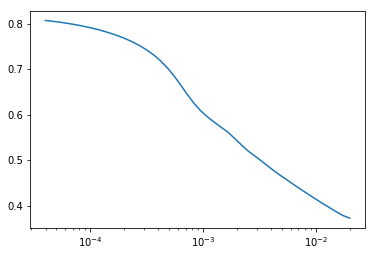

In [268]:
canv_learn.lr_find()
canv_learn.recorder.plot()

Total time: 06:29
epoch  train loss  valid loss
0      0.060497    0.059511    (00:19)
1      0.050961    0.050629    (00:19)
2      0.044277    0.045154    (00:19)
3      0.041674    0.041385    (00:19)
4      0.039866    0.042188    (00:19)
5      0.039195    0.044825    (00:19)
6      0.038459    0.038278    (00:19)
7      0.036800    0.036661    (00:19)
8      0.035725    0.037380    (00:19)
9      0.034930    0.035873    (00:20)
10     0.033856    0.034569    (00:20)
11     0.033529    0.034405    (00:20)
12     0.032190    0.032293    (00:19)
13     0.031466    0.031974    (00:19)
14     0.030728    0.032015    (00:19)
15     0.030170    0.031265    (00:19)
16     0.029669    0.030426    (00:19)
17     0.029540    0.030159    (00:19)
18     0.029325    0.030028    (00:19)
19     0.029229    0.029987    (00:19)



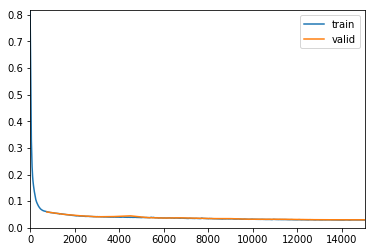

In [269]:
canv_learn.fit_one_cycle(20)

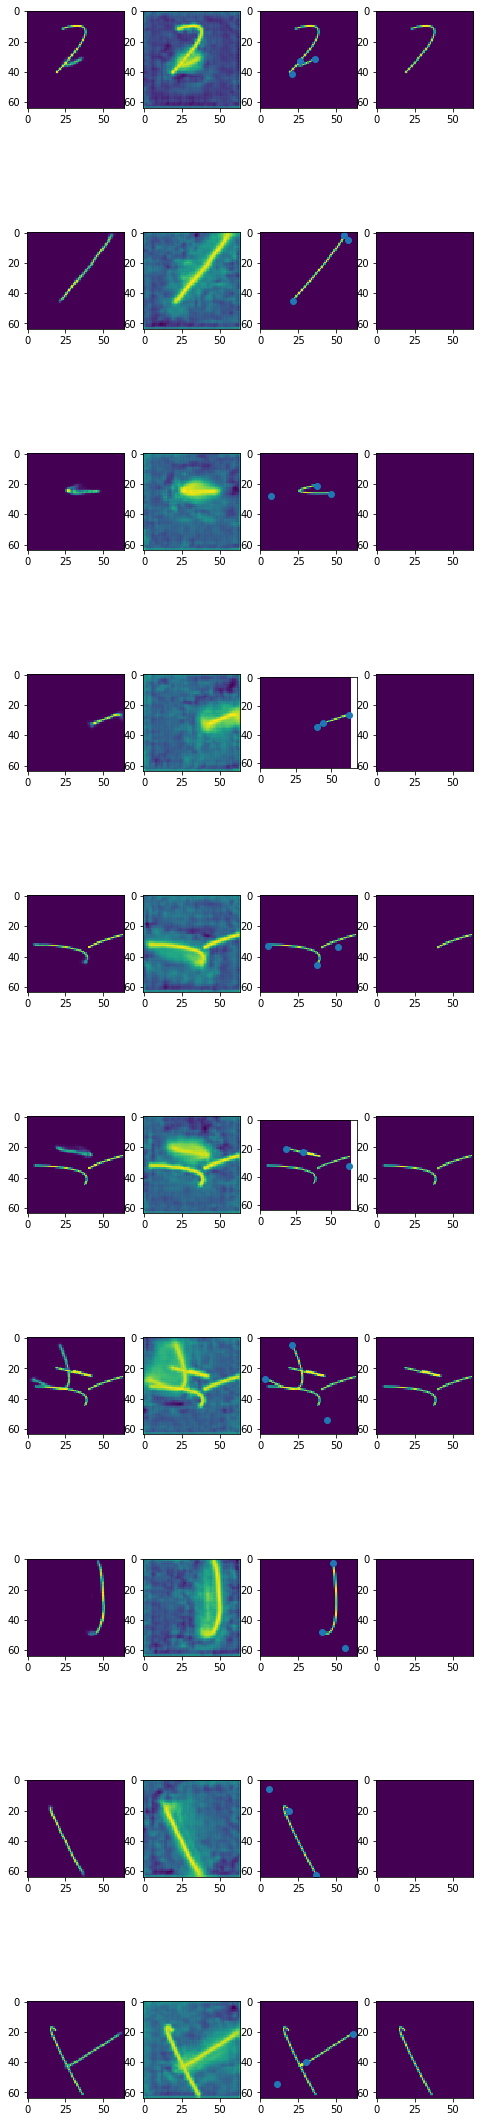

In [270]:
preview_canvas_withhint_logits(CanvasDataset(canvas_df[-20:]), canv_learn)

In [271]:
canv_learn.save('canv-gooddata-20kseq-20xonecycle')

## CoordConv Canvas implementation

### Definitions

In [13]:
class CoordCanvas(nn.Module):
    def __init__(self, action_dim, image_dim):
        super().__init__() 
        self.action_dim = action_dim
        self.image_dim = image_dim
        
        self.conv2cubes = ConvLayer(3+action_dim, image_dim//2, kernel_size=3, stride=1)
        
        self.rescubes = nn.Sequential(
            ResCube(image_dim//2),
            ResCube(image_dim//2),
            ResCube(image_dim//2),
        )
        
        self.conv_final = ConvLayer(image_dim//2, 1, kernel_size=3, stride=1, last=True)        
        
    def logits(self, hint, action):
        """
            action - 2d tensor of shape B x D (where D = action_dim)
        """
        B = action.shape[0]
        out = action.reshape((B, self.action_dim, 1, 1))
        out = out.repeat((1, 1, self.image_dim, self.image_dim))
        
        # tiled action layer of B x (C=action_dim) x H x W
        coord = get_coord(self.image_dim, B)
        out = (
            torch.cat((coord, hint, out), 1)
        ) # concatenated coordconv input of B x (C=3+action_dim) x H x W
        out = self.conv2cubes(out)
        out = self.rescubes(out)
        out = self.conv_final(out)
        return out
    
    def forward(self, hint, action):
        out = self.logits(hint, action)
        final = torch.sigmoid(out)
        return final

In [14]:
def get_coordcanv_learner(dataset_df, image_size, action_size):
    split = int(len(dataset_df) * 0.8)
    coordcanv_train_ds = CanvasDataset(dataset_df[:split])
    coordcanv_valid_ds = CanvasDataset(dataset_df[split:])
    coordcanv_db = DataBunch.create(coordcanv_train_ds, coordcanv_valid_ds, bs=64)
    coordcanv_learn = Learner(
        coordcanv_db, 
        CoordCanvas(action_size, image_size).cuda(),
        callback_fns=ShowGraph, 
        loss_fn=F.binary_cross_entropy,
        wd=0.001
    )
    return coordcanv_learn

### Training

In [510]:
coordcanv_learn = get_coordcanv_learner(canvas_df, 64, 6)

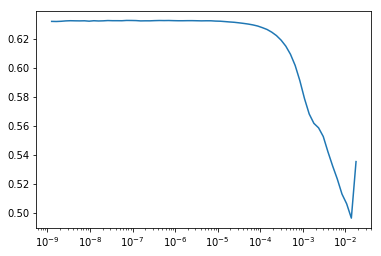

In [345]:
coordcanv_learn.lr_find(1e-10)
coordcanv_learn.recorder.plot()

Total time: 02:14
epoch  train loss  valid loss
0      0.055926    0.056077    (00:26)
1      0.043456    0.042607    (00:26)
2      0.036585    0.036378    (00:26)
3      0.030377    0.030728    (00:27)
4      0.028676    0.028969    (00:26)



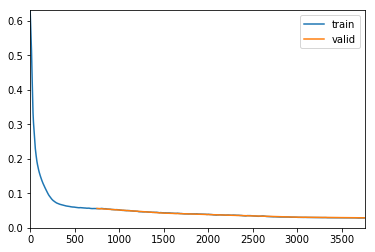

In [346]:
coordcanv_learn.fit_one_cycle(5)

In [348]:
coordcanv_learn.save('coordcanv-gooddata-20k-5xonecycle')

## Original Drawer Implementation 

### Definitions

In [180]:
class Drawer(nn.Module):
    def __init__(self, action_dim, timesteps, canvas_model):
        super().__init__()
        self.canvas_model = canvas_model
        self.action_dim = action_dim
        self.timesteps = timesteps
        self.image_convs = ConvPyramid()
        self.hint_convs = ConvPyramid()
        self.fcs = nn.Sequential(
            Flatten(),
            nn.Linear(8*8*32*2, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
        )
        
        self.rnn_size = 128
        self.nl = 1
        self.rnn = nn.LSTM(128, self.rnn_size, 1, batch_first = True)
        self.fcs_final = nn.Linear(self.rnn_size, action_dim)
        for p in canvas_model.parameters():
            p.requires_grad_(False)

    def init_hidden(self, bs):
        self.hidden = torch.zeros((self.nl, bs, self.rnn_size)).cuda()

    def forward(self, hint):
        bs = hint.shape[0]
        self.canvas_model.eval()
        self.init_hidden(bs)      
        image_in = torch.zeros_like(hint).cuda()
        actions = torch.zeros((bs, self.timesteps, self.action_dim)).cuda()
        for idx in range(self.timesteps):
            coord = get_coord(hint.shape[-1], bs)

            image_out = torch.cat(
                (image_in, coord), 1
            )
            hint_out = torch.cat(
                (hint, coord), 1
            )
            
            image_out = self.image_convs(image_out)
            hint_out = self.image_convs(hint_out)
        
            out = torch.cat((image_out, hint_out), 1)
            out = self.fcs(out)
            out, (self.hidden, _) = self.rnn(out.unsqueeze(1), (self.hidden, torch.zeros_like(self.hidden).cuda()))
            action = torch.sigmoid(self.fcs_final(out)).reshape((bs, self.action_dim))      
            render = self.canvas_model(image_in, action)
            actions[:, idx] = action
            image_in = torch.max(image_in, render)
        return image_in, actions

In [467]:
def image_action_loss(output, target):
    ims, acts = output
    return F.binary_cross_entropy(ims, target)

In [359]:
def get_drawer_learner(dataset_df, image_size, action_size):
    canvas_learner = get_canvas_learner(canvas_df, image_size)
    canvas_learner.load('canv-gooddata-20kseq-20xonecycle')
    split = int(len(dataset_df) * 0.8)
    drawer_train_ds = DrawerDataset(dataset_df[:split])
    drawer_valid_ds = DrawerDataset(dataset_df[split:])
    drawer_db = DataBunch.create(drawer_train_ds, drawer_valid_ds, bs=128)
    drawer_learn = Learner(
        drawer_db, 
        Drawer(action_size, 5, canvas_learner.model).cuda(),
        callback_fns=ShowGraph, 
        loss_fn=image_action_loss,
    )
    return drawer_learn

### Training

In [360]:
drawer_learn = get_drawer_learner(drawer_df, 64, 6)

In [363]:
drawer_learn.lr_find(10e-3, 10e1)

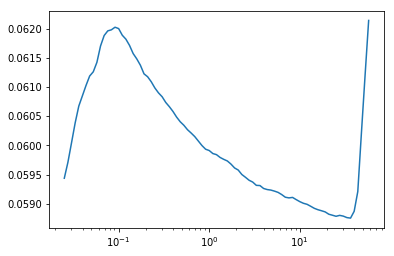

In [364]:
drawer_learn.recorder.plot()

KeyboardInterrupt: 

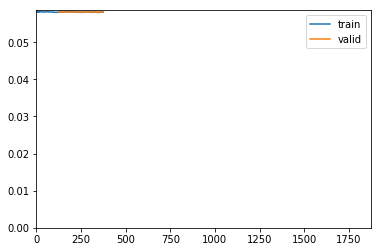

In [366]:
drawer_learn.fit_one_cycle(15, 1)

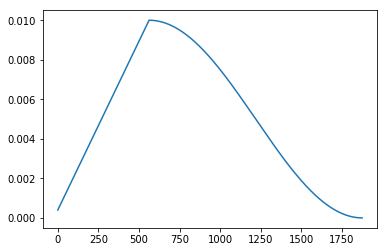

In [319]:
drawer_learn.recorder.plot_lr()

Total time: 05:04
epoch  train loss  valid loss
0      0.237899    0.240897    (00:20)
1      0.237740    0.241115    (00:20)
2      0.237351    0.240594    (00:20)
3      0.237252    0.240048    (00:20)
4      0.236594    0.240092    (00:20)
5      0.235801    0.239072    (00:20)
6      0.233829    0.237240    (00:20)
7      0.231950    0.236242    (00:20)
8      0.231015    0.235424    (00:20)
9      0.229539    0.234900    (00:20)
10     0.227775    0.234362    (00:20)
11     0.226666    0.233725    (00:20)
12     0.225449    0.233568    (00:20)
13     0.225031    0.233440    (00:20)
14     0.224578    0.233431    (00:20)



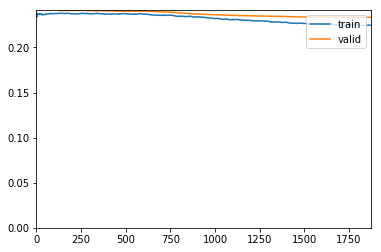

In [320]:
drawer_learn.fit_one_cycle(15, 2e-3)

In [321]:
drawer_learn.save("drawer-22-20k-40x2xcycle")

In [343]:
it = iter(DrawerDataset(drawer_df[-20:]))

## Trash Bin

In [347]:
X, y = next(it)
out = drawer_learn.model(X.unsqueeze(0).cuda())

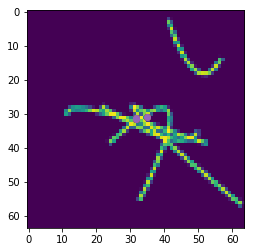

In [350]:
X, y = next(it)
out = drawer_learn.model(X.unsqueeze(0).cuda())
plt.imshow(to_np(X.detach().reshape((64,64))))
acts = to_np(out[1].detach())[0] * 64
for i in range(acts.shape[0]):
    plt.scatter(acts[i, 0::2], acts[i, 1::2])

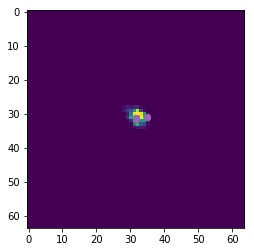

In [351]:
plt.imshow(to_np(out[0].detach().reshape((64,64))))
acts = to_np(out[1].detach())[0] * 64
for i in range(acts.shape[0]):
    plt.scatter(acts[i, 0::2], acts[i, 1::2])

In [30]:
acts  /64

array([[0.6063852 , 0.5879027 , 0.6382768 , 0.57877153, 0.87650687,
        0.59500605, 0.63630414],
       [0.49565864, 0.2682416 , 0.37923595, 0.7335658 , 0.9849194 ,
        0.4855384 , 0.740606  ],
       [0.5756339 , 0.6028776 , 0.4310644 , 0.64541066, 0.9232623 ,
        0.53924316, 0.36865196],
       [0.54169834, 0.137618  , 0.07630911, 0.758919  , 0.9954839 ,
        0.25762716, 0.45905975],
       [0.6000505 , 0.4965953 , 0.19747855, 0.6669985 , 0.98583025,
        0.37351876, 0.14256383]], dtype=float32)

In [185]:
def masked_canvas_loss(canvas, loss_fn):
    canvas.eval()
    def helper(output, target, hint, mask):
        B, T = output.shape[0:2]
        
        canvas_output = canvas(
            squash_front(hint),
            squash_front(output)
        ).reshape(target.shape)
        
        mask = mask.flatten().detach().type(torch.float)
        mask = mask.reshape(B, T, 1, 1, 1)
        weight = mask.repeat((1, 1, 1, 64, 64))
        return loss_fn(canvas_output, target, weight=weight, reduction='sum') / weight.sum()
        """c
        canvas_output = weight * canvas_output
        target = weight * target
        return (loss_fn(
            canvas_output, 
            target,
            reduction='sum'
        ) / weight.sum())
        """
    return helper

## MNIST reconstruction task

In [445]:
class MNISTUnsupervisedDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mn = mnist_dataset
    def __len__(self):
        return len(self.mn)
    def __getitem__(self, idx):
        im = self.mn[idx][0]
        return im, im

In [544]:
(64-28) // 2

18

In [545]:
mnist_transforms = transforms.Compose([
    transforms.Pad((18, 18)),
    transforms.ToTensor(),
    #transforms.Lambda(lambda ts: ts.unsqueeze(0))
])

mnist_train_loader = MNISTUnsupervisedDataset(
    datasets.MNIST(
        '../data', 
        train=True, 
        transform=mnist_transforms
    )
)
mnist_test_loader = MNISTUnsupervisedDataset(
    datasets.MNIST(
        '../data', 
        train=False, 
        transform=mnist_transforms
    )
)

In [577]:
canvas_learner = get_canvas_learner(canvas_df, 64)
canvas_learner.load('canv-gooddata-20kseq-20xonecycle')

drawer_db = DataBunch.create(mnist_train_loader, mnist_test_loader, bs=64)
drawer_learn = Learner(
    drawer_db, 
    Drawer(6, 4, canvas_learner.model).cuda(),
    callback_fns=ShowGraph, 
    loss_fn=image_action_loss,
)

Total time: 05:14
epoch  train loss  valid loss
0      0.060785    0.059915    (01:02)
1      0.047515    0.047102    (01:02)
2      0.043013    0.042819    (01:03)
3      0.041315    0.041078    (01:03)
4      0.041039    0.040720    (01:02)



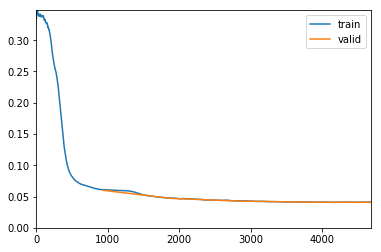

In [578]:
drawer_learn.fit_one_cycle(5, 10e-5)

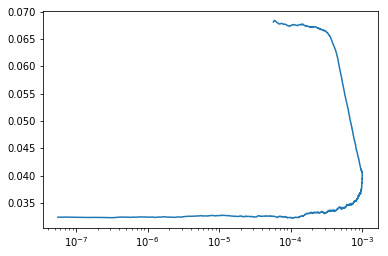

In [549]:
drawer_learn.recorder.plot()

In [615]:
it = iter(mnist_train_loader)

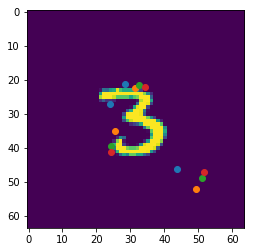

In [639]:
X, y = next(it)
out = drawer_learn.model(X.unsqueeze(0).cuda())
plt.imshow(to_np(X.detach().reshape((64,64))))
acts = to_np(out[1].detach())[0] * 64
for i in range(acts.shape[0]):
    plt.scatter(acts[i, 0::2], acts[i, 1::2])

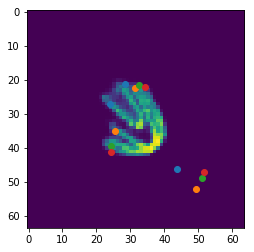

In [640]:
plt.imshow(to_np(out[0].detach().reshape((64,64))))
acts = to_np(out[1].detach())[0] * 64
for i in range(acts.shape[0]):
    plt.scatter(acts[i, 0::2], acts[i, 1::2])

In [641]:
out = canvas_learn.model(torch.zeros_like(X).cuda().unsqueeze(0), torch.tensor([0.25,0.25,0.75,0.75, 0.5,0.5]).cuda().float().unsqueeze(0))

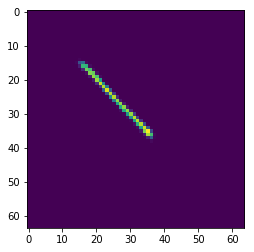

In [642]:
plt.imshow(to_np(out.squeeze().detach()))

## Notes

To Do:
- separate models out into class files
- spatial pyramid pooling
- ~~collage dataset~~
- compare with baseline linear transform (in circle case at least)
- ablation study
- two-stream (image, action) rnn canvas with hidden state